In [2]:
!head -n 10 babynames/yob1880.txt

Mary,F,7065
Anna,F,2604
Emma,F,2003
Elizabeth,F,1939
Minnie,F,1746
Margaret,F,1578
Ida,F,1472
Alice,F,1414
Bertha,F,1320
Sarah,F,1288


In [4]:
import pandas as pd
names1880 = pd.read_csv('babynames/yob1880.txt',
                        names=['name', 'sex', 'births'])
names1880

,name,sex,births
0,Mary,F,7065
1,Anna,F,2604
2,Emma,F,2003
3,Elizabeth,F,1939
4,Minnie,F,1746
...,...,...,...
1995,Woodie,M,5
1996,Worthy,M,5
1997,Wright,M,5
1998,York,M,5


In [5]:
names1880.groupby('sex').births.sum()

sex
F     90993
M    110493
Name: births, dtype: int64

In [6]:
years = range(1880, 2011)

pieces = []
columns = ['name', 'sex', 'births']

for year in years:
    path = 'babynames/yob%d.txt' % year
    frame = pd.read_csv(path, names=columns)

    frame['year'] = year
    pieces.append(frame)

# Concatenate everything into a single DataFrame
names = pd.concat(pieces, ignore_index=True)

In [7]:
names

,name,sex,births,year
0,Mary,F,7065,1880
1,Anna,F,2604,1880
2,Emma,F,2003,1880
3,Elizabeth,F,1939,1880
4,Minnie,F,1746,1880
...,...,...,...,...
1690779,Zymaire,M,5,2010
1690780,Zyonne,M,5,2010
1690781,Zyquarius,M,5,2010
1690782,Zyran,M,5,2010


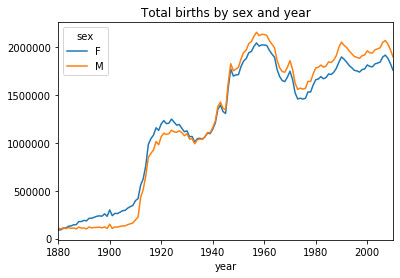

In [8]:
total_births = names.pivot_table('births', index='year',
                                 columns='sex', aggfunc=sum)
total_births.tail()
total_births.plot(title='Total births by sex and year')

In [9]:
def add_prop(group):
    group['prop'] = group.births / group.births.sum()
    return group
names = names.groupby(['year', 'sex']).apply(add_prop)

In [10]:
names

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
1690779,Zymaire,M,5,2010,0.000003
1690780,Zyonne,M,5,2010,0.000003
1690781,Zyquarius,M,5,2010,0.000003
1690782,Zyran,M,5,2010,0.000003


In [11]:
names.groupby(['year', 'sex']).prop.sum()

year  sex
1880  F      1.0
      M      1.0
1881  F      1.0
      M      1.0
1882  F      1.0
            ... 
2008  M      1.0
2009  F      1.0
      M      1.0
2010  F      1.0
      M      1.0
Name: prop, Length: 262, dtype: float64

In [12]:
def get_top1000(group):
    return group.sort_values(by='births', ascending=False)[:1000]
grouped = names.groupby(['year', 'sex'])
top1000 = grouped.apply(get_top1000)
# Drop the group index, not needed
top1000.reset_index(inplace=True, drop=True)

In [13]:
pieces = []
for year, group in names.groupby(['year', 'sex']):
    pieces.append(group.sort_values(by='births', ascending=False)[:1000])
top1000 = pd.concat(pieces, ignore_index=True)

In [14]:
top1000

,name,sex,births,year,prop
0,Mary,F,7065,1880,0.077643
1,Anna,F,2604,1880,0.028618
2,Emma,F,2003,1880,0.022013
3,Elizabeth,F,1939,1880,0.021309
4,Minnie,F,1746,1880,0.019188
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


### Analyzing Naming Trends

In [15]:
boys = top1000[top1000.sex == 'M']
girls = top1000[top1000.sex == 'F']

In [16]:
total_births = top1000.pivot_table('births', index='year',
                                   columns='name',
                                   aggfunc=sum)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131 entries, 1880 to 2010
Columns: 6868 entries, Aaden to Zuri
dtypes: float64(6868)
memory usage: 6.9 MB


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002D5E90537F0>,
      dtype=object)

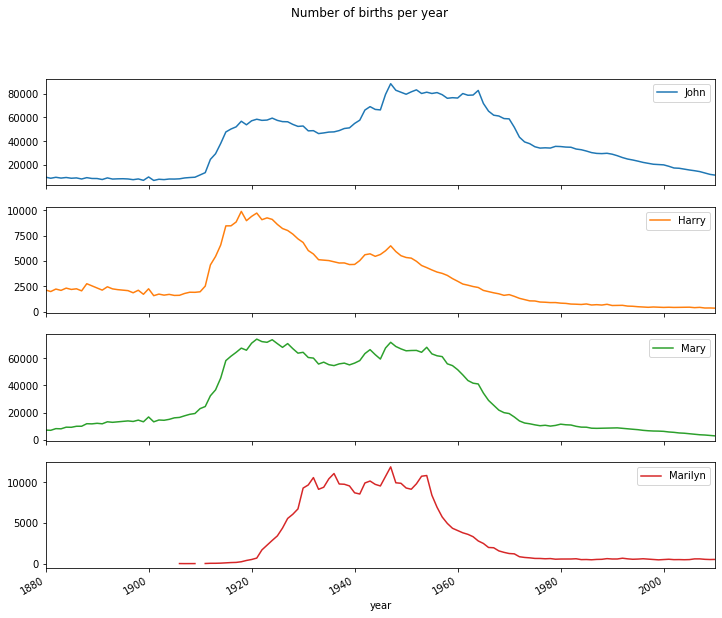

In [17]:
total_births.info()
subset = total_births[['John', 'Harry', 'Mary', 'Marilyn']]
subset.plot(subplots=True, figsize=(12, 10), grid=False,
            title="Number of births per year")

#### Measuring the increase in naming diversity

In [21]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

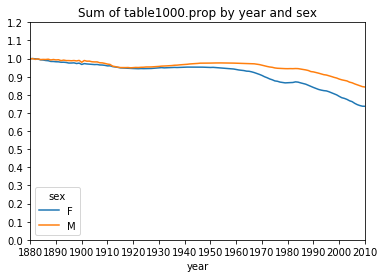

In [22]:
table = top1000.pivot_table('prop', index='year',
                            columns='sex', aggfunc=sum)
table.plot(title='Sum of table1000.prop by year and sex',
           yticks=np.linspace(0, 1.2, 13), xticks=range(1880, 2020, 10))

In [23]:
df = boys[boys.year == 2010]
df

,name,sex,births,year,prop
260877,Jacob,M,21875,2010,0.011523
260878,Ethan,M,17866,2010,0.009411
260879,Michael,M,17133,2010,0.009025
260880,Jayden,M,17030,2010,0.008971
260881,William,M,16870,2010,0.008887
...,...,...,...,...,...
261872,Camilo,M,194,2010,0.000102
261873,Destin,M,194,2010,0.000102
261874,Jaquan,M,194,2010,0.000102
261875,Jaydan,M,194,2010,0.000102


In [24]:
prop_cumsum = df.sort_values(by='prop', ascending=False).prop.cumsum()
prop_cumsum[:10]
prop_cumsum.values.searchsorted(0.5)

116

In [25]:
df = boys[boys.year == 1900]
in1900 = df.sort_values(by='prop', ascending=False).prop.cumsum()
in1900.values.searchsorted(0.5) + 1

25

In [26]:
def get_quantile_count(group, q=0.5):
    group = group.sort_values(by='prop', ascending=False)
    return group.prop.cumsum().values.searchsorted(q) + 1

diversity = top1000.groupby(['year', 'sex']).apply(get_quantile_count)
diversity = diversity.unstack('sex')

In [27]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

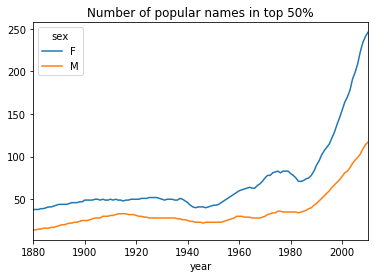

In [28]:
diversity.head()
diversity.plot(title="Number of popular names in top 50%")

#### The “last letter” revolution

In [29]:
# extract last letter from name column
get_last_letter = lambda x: x[-1]
last_letters = names.name.map(get_last_letter)
last_letters.name = 'last_letter'

table = names.pivot_table('births', index=last_letters,
                          columns=['sex', 'year'], aggfunc=sum)

In [30]:
subtable = table.reindex(columns=[1910, 1960, 2010], level='year')
subtable.head()

sex                 F                            M                    
year             1910      1960      2010     1910      1960      2010
last_letter                                                           
a            108376.0  691247.0  670605.0    977.0    5204.0   28438.0
b                 NaN     694.0     450.0    411.0    3912.0   38859.0
c                 5.0      49.0     946.0    482.0   15476.0   23125.0
d              6750.0    3729.0    2607.0  22111.0  262112.0   44398.0
e            133569.0  435013.0  313833.0  28655.0  178823.0  129012.0

In [31]:
subtable.sum()
letter_prop = subtable / subtable.sum()
letter_prop

sex                 F                             M                    
year             1910      1960      2010      1910      1960      2010
last_letter                                                            
a            0.273390  0.341853  0.381240  0.005031  0.002440  0.014980
b                 NaN  0.000343  0.000256  0.002116  0.001834  0.020470
c            0.000013  0.000024  0.000538  0.002482  0.007257  0.012181
d            0.017028  0.001844  0.001482  0.113858  0.122908  0.023387
e            0.336941  0.215133  0.178415  0.147556  0.083853  0.067959
f                 NaN  0.000010  0.000055  0.000783  0.004325  0.001188
g            0.000144  0.000157  0.000374  0.002250  0.009488  0.001404
h            0.051529  0.036224  0.075852  0.045562  0.037907  0.051670
i            0.001526  0.039965  0.031734  0.000844  0.000603  0.022628
j                 NaN       NaN  0.000090       NaN       NaN  0.000769
k            0.000121  0.000156  0.000356  0.036581  0.049384  0.018541
l            0.043189  0.033867  0.026356  0.065016  0.104904  0.070367
m            0.001201  0.008613  0.002588  0.058044  0.033827  0.024657
n            0.079240  0.130687  0.140210  0.143415  0.152522  0.362771
o            0.001660  0.002439  0.001243  0.017065  0.012829  0.042681
p            0.000018  0.000023  0.000020  0.003172  0.005675  0.001269
q                 NaN       NaN  0.000030       NaN       NaN  0.000180
r            0.013390  0.006764  0.018025  0.064481  0.031034  0.087477
s            0.039042  0.012764  0.013332  0.130815  0.102730  0.065145
t            0.027438  0.015201  0.007830  0.072879  0.065655  0.022861
u            0.000684  0.000574  0.000417  0.000124  0.000057  0.001221
v                 NaN  0.000060  0.000117  0.000113  0.000037  0.001434
w            0.000020  0.000031  0.001182  0.006329  0.007711  0.016148
x            0.000015  0.000037  0.000727  0.003965  0.001851  0.008614
y            0.110972  0.152569  0.116828  0.077349  0.160987  0.058168
z            0.002439  0.000659  0.000704  0.000170  0.000184  0.001831

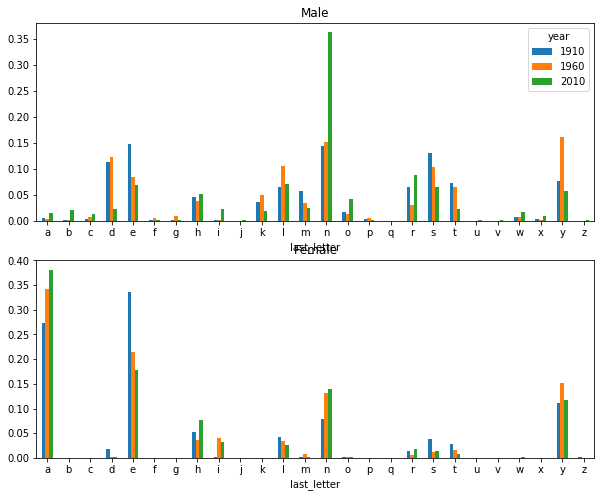

In [32]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1, figsize=(10, 8))
letter_prop['M'].plot(kind='bar', rot=0, ax=axes[0], title='Male')
letter_prop['F'].plot(kind='bar', rot=0, ax=axes[1], title='Female',
                      legend=False)

In [33]:
plt.subplots_adjust(hspace=0.25)

<Figure size 432x288 with 0 Axes>

In [34]:
letter_prop = table / table.sum()
dny_ts = letter_prop.loc[['d', 'n', 'y'], 'M'].T
dny_ts.head()

last_letter,d,n,y
year,,,
1880,0.083055,0.153213,0.075760
1881,0.083247,0.153214,0.077451
1882,0.085340,0.149560,0.077537
1883,0.084066,0.151646,0.079144
1884,0.086120,0.149915,0.080405


In [35]:
plt.close('all')

In [36]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

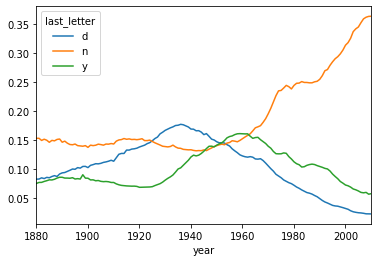

In [37]:
dny_ts.plot()

#### Boy names that became girl names (and vice versa)

In [38]:
all_names = pd.Series(top1000.name.unique())
lesley_like = all_names[all_names.str.lower().str.contains('lesl')]
lesley_like

632     Leslie
2294    Lesley
4262    Leslee
4728     Lesli
6103     Lesly
dtype: object

In [39]:
filtered = top1000[top1000.name.isin(lesley_like)]
filtered.groupby('name').births.sum()

name
Leslee      1082
Lesley     35022
Lesli        929
Leslie    370429
Lesly      10067
Name: births, dtype: int64

In [40]:
table = filtered.pivot_table('births', index='year',
                             columns='sex', aggfunc='sum')
table = table.div(table.sum(1), axis=0)
table.tail()

sex,F,M
year,,
2006,1.0,NaN
2007,1.0,NaN
2008,1.0,NaN
2009,1.0,NaN
2010,1.0,NaN


In [41]:
fig = plt.figure()

<Figure size 432x288 with 0 Axes>

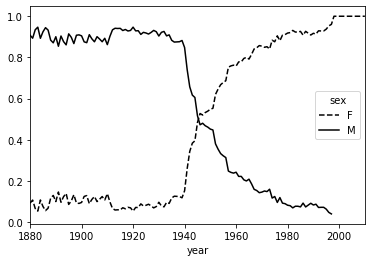

In [42]:
table.plot(style={'M': 'k-', 'F': 'k--'})